In [1]:
import numpy as np # linear algebra
import pandas as pd 
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [3]:
class CFG:    
    # config
    WORK_DIR = '../input/cassava-leaf-disease-classification'
    BATCH_SIZE = 32
    EPOCHS = 10
    TARGET_SIZE = 512

In [4]:
import os
train_labels = pd.read_csv(os.path.join(CFG.WORK_DIR, "train.csv"))

STEPS_PER_EPOCH = len(train_labels)*0.8 / CFG.BATCH_SIZE
VALIDATION_STEPS = len(train_labels)*0.2 / CFG.BATCH_SIZE

    
train_labels.head()

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_labels.label = train_labels.label.astype('str')
train_labels.label = train_labels.label.astype('str')

train_datagen = ImageDataGenerator(validation_split = 0.2, preprocessing_function = None,
                                     rotation_range = 45, zoom_range = 0.2,
                                     horizontal_flip = True, vertical_flip = True,
                                     fill_mode = 'nearest', shear_range = 0.1,
                                     height_shift_range = 0.1, width_shift_range = 0.1)

train_generator = train_datagen.flow_from_dataframe(train_labels, directory = os.path.join(CFG.WORK_DIR, "train_images"),
                         subset = "training", x_col = "image_id",
                         y_col = "label", target_size = (CFG.TARGET_SIZE, CFG.TARGET_SIZE),
                         batch_size = CFG.BATCH_SIZE, class_mode = "sparse")


validation_datagen = ImageDataGenerator(validation_split = 0.2)

validation_generator = validation_datagen.flow_from_dataframe(train_labels,
                         directory = os.path.join(CFG.WORK_DIR, "train_images"),
                         subset = "validation", x_col = "image_id",
                         y_col = "label", target_size = (CFG.TARGET_SIZE, CFG.TARGET_SIZE),
                         batch_size = CFG.BATCH_SIZE, class_mode = "sparse")

Found 17118 validated image filenames belonging to 5 classes.
Found 4279 validated image filenames belonging to 5 classes.


In [6]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
#initialise base model
IMG_SHAPE = (CFG.TARGET_SIZE, CFG.TARGET_SIZE, 3)
base_model = MobileNetV2(input_shape=IMG_SHAPE, input_tensor=None,
                                                include_top=False, 
                                                weights='imagenet')
base_model.trainable = True

2023-01-14 17:02:37.628748: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-14 17:02:37.722240: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-14 17:02:37.723042: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-14 17:02:37.724995: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

9420800/9406464 [==============================] - 0s 0us/step


In [7]:
#define model
model = tf.keras.Sequential()
model.add(base_model)
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dense(320, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(320, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(38, activation='relu'))
model.add(tf.keras.layers.Dense(5,activation='softmax'))
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 16, 16, 1280)      2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 320)               409920    
_________________________________________________________________
dropout (Dropout)            (None, 320)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 320)               102720    
_________________________________________________________________
dropout_1 (Dropout)          (None, 320)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 38)                1

In [8]:
#compile model
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9), 
      loss = "sparse_categorical_crossentropy", 
      metrics=['accuracy'])
# Reduce learning rate when there is a change lesser than <min_delta> in <val_accuracy> for more than <patience> epochs
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy',
                                                 mode = 'max',
                                                 min_delta = 0.01,
                                                 patience = 3,
                                                 factor = 0.25,
                                                 verbose = 1,
                                                 cooldown = 0,
                                                 min_lr = 0.00000001)

# Stop the training process when there is a change lesser than <min_delta> in <val_accuracy> for more than <patience> epochs
early_stopper = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy',
                                                 mode = 'max',
                                                 min_delta = 0.005,
                                                 patience = 10,
                                                 verbose = 1,
                                                 restore_best_weights = True)

#  Save best model every epoch
model_checkpoint = tf.keras.callbacks.ModelCheckpoint('.')
#fit the model
history = model.fit(train_generator, 
                    epochs=CFG.EPOCHS,
                    validation_data = validation_generator,
                    callbacks=[early_stopper, reduce_lr,model_checkpoint])

2023-01-14 17:02:44.059227: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2023-01-14 17:02:51.443082: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


535/535 [==============================] - 1454s 3s/step - loss: 0.8003 - accuracy: 0.6968 - val_loss: 1.0334 - val_accuracy: 0.6948


2023-01-14 17:27:08.350281: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/10
535/535 [==============================] - 1309s 2s/step - loss: 0.4906 - accuracy: 0.8313 - val_loss: 0.7597 - val_accuracy: 0.7822


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 3/10
535/535 [==============================] - 1293s 2s/step - loss: 0.4334 - accuracy: 0.8510 - val_loss: 0.6521 - val_accuracy: 0.8086


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 4/10
535/535 [==============================] - 1305s 2s/step - loss: 0.3986 - accuracy: 0.8639 - val_loss: 0.6535 - val_accuracy: 0.8252


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 5/10
535/535 [==============================] - 1298s 2s/step - loss: 0.3767 - accuracy: 0.8696 - val_loss: 0.4580 - val_accuracy: 0.8602


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 6/10
535/535 [==============================] - 1303s 2s/step - loss: 0.3676 - accuracy: 0.8730 - val_loss: 0.5314 - val_accuracy: 0.8495


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 7/10
535/535 [==============================] - 1305s 2s/step - loss: 0.3576 - accuracy: 0.8795 - val_loss: 0.5510 - val_accuracy: 0.8387


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 8/10
535/535 [==============================] - 1326s 2s/step - loss: 0.3373 - accuracy: 0.8845 - val_loss: 0.4237 - val_accuracy: 0.8642

Epoch 00008: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 9/10
535/535 [==============================] - 1332s 2s/step - loss: 0.3157 - accuracy: 0.8906 - val_loss: 0.3921 - val_accuracy: 0.8729


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 10/10
535/535 [==============================] - 1322s 2s/step - loss: 0.3084 - accuracy: 0.8938 - val_loss: 0.3969 - val_accuracy: 0.8698


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


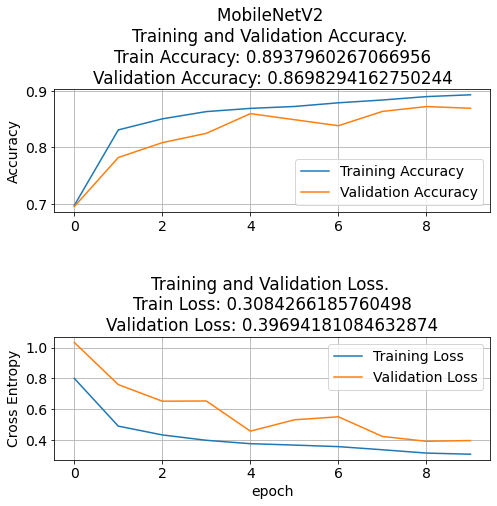

In [9]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

#plot results
#accuracy
plt.figure(figsize=(8, 8))
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['font.size'] = 14
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.facecolor'] = 'white'
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title(f'MobileNetV2 \nTraining and Validation Accuracy. \nTrain Accuracy: {str(acc[-1])}\nValidation Accuracy: {str(val_acc[-1])}')

#loss
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title(f'Training and Validation Loss. \nTrain Loss: {str(loss[-1])}\nValidation Loss: {str(val_loss[-1])}')
plt.xlabel('epoch')
plt.tight_layout(pad=3.0)
plt.show()

In [10]:
# save the model 
saved_model = tf.keras.models.load_model('.')
file_h5 = "cassava_model.h5"
tf.keras.models.save_model(saved_model, file_h5)